In [1]:
import import_ipynb
from ConsistencyIndexes import *
import torch.nn.functional as Fun
import torch
from torch import optim
import matplotlib.pyplot as plt
import time

importing Jupyter notebook from ConsistencyIndexes.ipynb
importing Jupyter notebook from Functions.ipynb


## Extract Parameters from Dictionary

In [2]:
#Extract kernels and weights from Parameters
def Extract(Params):
    k = Params['k']
    kt = Params['kt']
    kb = Params['kb']
    return k,kt,kb

## Generate Random Values for Parameters

In [3]:
def Gen_Params(k_size,N,N_k):
    # Kernels for Current Frame
    k = [torch.rand(3,3,k_size,k_size,requires_grad=True) for _ in range(N_k)]     
    # Kernels for Temporal Consistency
    kt = [[torch.rand(3,3,k_size,k_size,requires_grad=True) for _ in range(N_k)]  for _ in range(2*N)]
    kb = [[torch.rand(3,3,k_size,k_size,requires_grad=True) for _ in range(N_k)]  for _ in range(2*N)]
    return k,kt,kb

## Objective Function

$$ F_{objective}(V,x,k_{x},k_{time},w_{time})= LeakyReLu(FeatureExtraction(V[\lfloor N/2 \rfloor],k_{x}) + \sum_{i=0}^{\lfloor \frac{N}{2}\rfloor-1} FeatureExtraction(V[i],k_{time}[i]) + \sum_{i=\lfloor \frac{N}{2}\rfloor+1}^{N} FeatureExtraction(V[i],k_{time}[i])) $$
<br>Where $V$ is a sequence of frames in a video of length $N$ and $V[\lfloor N/2 \rfloor]$ is the current frame. Also, $k_{x}$ is a list of kernels to exctract the current frame features and $k_{time}$ is lists of lists of kernels used to extract the features of the adjacent frames. The FeatureExtraction function is a function of consecutive convolutions with a LeakyReLu function.

In [4]:
def ObjFun(V,x,k,kt,kb):
    N = len(kt) #Number of adjacent frames
    k_size = k[0].shape[-1] # kernel size
    N_k = len(k[0]) #Number of kernels
    encodes = V[:N//2]+V[N//2+1:]
    sp = k_size//2 #stride
    # Encoder
    for i in k:
        x = Fun.leaky_relu(Fun.conv2d(x,i,stride=1,padding=sp))
    # Temporal Encoder
    for i in range(len(encodes)):
         for j in kt[i]:  
            encodes[i] = Fun.leaky_relu(Fun.conv2d(encodes[i],j,stride=1,padding=sp))
            
    # Add latent values
    for i in range(len(encodes)):
        x = x + encodes[i]

    return Fun.leaky_relu(x)

## Draw Inconsistencies and noise to frame

In [5]:
def AddOneInc1(F):
    # Convert to NumPy Array
    F = F.squeeze(0).permute(1, 2, 0).cpu().numpy() * 255
    # Copy of original array
    I = F.astype(np.uint8).copy()
    # Random location
    x, y = random.randint(0, 2 * I.shape[0] // 3), random.randint(0, 2 * I.shape[1] // 3)
    # Random size
    l = random.randint(5,I.shape[1]//20)
    # Random option
    Op = random.randint(0, 5)
    if Op == 0: #Draw square with changes color ranges
        I[x:x + l, y:y + l] = change_range_colors(I[x:x + l, y:y + l], (random.randint(30, 140), random.randint(30, 140), random.randint(30, 140)), (random.randint(150, 255), random.randint(150, 255), random.randint(150, 255)))
    elif Op == 1: #Draw square with random color
        R, G, B = random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)
        I[x:x + l, y:y + l] = change_range_colors(I[x:x + l, y:y + l], (R, G, B), (R, G, B))
    elif Op == 2: #Draw line with random color
        Thick = random.randint(1, 10)
        l2 = random.randint(5, I.shape[1]//15)
        I = cv2.line(I, (x, y), (x + l, y + l2), (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)), Thick)
    elif Op == 3: #Draw black line
        Thick = random.randint(1, 5)
        l2 = random.randint(5, I.shape[1]//20)
        I = cv2.line(I, (x, y), (x + l, y + l2), (0, 0, 0), Thick)  
    elif Op == 4: #Add a square of noise
        I[x:x+l,y:y+l] = I[x:x+l,y:y+l] + np.random.random_integers(-10,10,I[x:x+l,y:y+l].shape)
    else: #Convolution with a random kernel
        kernel = np.random.rand(3,3)
        I[x:x+l,y:y+l] = cv2.filter2D(I[x:x+l,y:y+l],-1,kernel)
    # Convert back to tensor
    I_tensor = torch.tensor(I, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)/255.0
    return I_tensor

## Optical Flow Function

In [6]:
def OF(img1,img2,iterations=100):
    def rgb_to_grayscale(img): #NTSC Formula (National Television System Committee)
        return 0.2989 * img[0, :, :] + 0.5870 * img[1, :, :] + 0.1140 * img[2, :, :] #Coeficients add to one
    #Convert to Gray Scale
    I1 = rgb_to_grayscale(img1)
    I2 = rgb_to_grayscale(img2)
    # Initialize optical flow vectors
    x = torch.zeros_like(I1, requires_grad=True)
    y = torch.zeros_like(I1, requires_grad=True)
    # Define convolution kernels for gradients
    kernel_x = torch.tensor([[[[-1, 1], [-1, 1]]]], dtype=torch.float32)
    kernel_y = torch.tensor([[[[-1, -1], [1, 1]]]], dtype=torch.float32)
    # Compute gradients with padding that maintains the original image size
    Ix = Fun.conv2d(I1.unsqueeze(0).unsqueeze(0),kernel_x,padding=(0,1)).squeeze(0).squeeze(0)
    Iy = Fun.conv2d(I1.unsqueeze(0).unsqueeze(0),kernel_y,padding=(1,0)).squeeze(0).squeeze(0)
    It = I2 - I1  # Temporal gradient
    # Ensure all tensors have matching dimensions by cropping to the smallest dimensions
    min_h = min(Ix.shape[-2],Iy.shape[-2],It.shape[-2],I1.shape[-2])
    min_w = min(Ix.shape[-1],Iy.shape[-1],It.shape[-1],I1.shape[-1])
    Ix = Ix[:min_h, :min_w]
    Iy = Iy[:min_h, :min_w]
    It = It[:min_h, :min_w]
    x = x[:min_h, :min_w]
    y = y[:min_h, :min_w]
    # Iteratively update the optical flow
    for _ in range(iterations):
        # Average flow in the neighborhood
        x_avg = Fun.avg_pool2d(x.unsqueeze(0).unsqueeze(0),3,stride=1,padding=1).squeeze(0).squeeze(0)
        y_avg = Fun.avg_pool2d(y.unsqueeze(0).unsqueeze(0),3,stride=1,padding=1).squeeze(0).squeeze(0)
        # Optical flow update step based on Horn-Schunck method
        P = Ix * x_avg + Iy * y_avg + It
        D = Ix ** 2 + Iy ** 2
        x = x_avg - (Ix * P) / D
        y = y_avg - (Iy * P) / D
    # Stack x and y to form the flow tensor
    flow = torch.stack((x, y), dim=0)
    return flow

## Training Function

In [8]:
def train(Input, Params=None, N=1, k_size=1, N_k=1, Epochs=10, Steps=5, LR=1e-3):
    if Params is None: #If parameters are not given
        k, kt, kb = Gen_Params(k_size, N, N_k) #Generate Starting Parameters
    else:
        k, kt, kb = Extract(Params) #Load Parameters
        k_size = k[0][-1].shape[-1]
        N = len(kt)//2
        N_k = len(k)
    sp = k_size // 2 #Stride
    if N > len(Input[0]) // 2: #Ensure Videoclips have enough frames
        print("Not enough frames for size", N)
        return None, None, None
    # Set optimizer parameters
    optimizer = optim.NAdam([p for p in k] + [j for p in kt for j in p], lr=LR)
    Loss = [] #Epochs loss
    LossAll = [] #Frames loss
    #Set videos to correct format
    In = [[torch.tensor(cv2.resize(i, (320, 320), interpolation=cv2.INTER_AREA),
                        dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255.0 for i in v] for v in Input]
    #Edges kernel
    ke = torch.tensor([[[[0, -1, 0], [-1, 4, -1], [0, -1, 0]]]*3]*3, dtype=torch.float32)
    #Calculate edges for each videoclip
    Edges = [[F.conv2d(i, ke, stride=sp, padding=sp) for i in v] for v in In]
    #Steps and time for time estimation
    total_steps = Epochs * len(In) * (len(In[0]) - 2 * N)
    step_count = 0
    start_time = time.time()
    for epoch in range(Epochs):
        total_loss = 0.0
        random.shuffle(In) #Shuffle Videoclips
        for v in range(len(In)): #For each video
            for f in range(len(In[v]) - 2 * N): #For each frame in video
                step_count += 1 #step count for time estimation
                first, current, last = f, f + N // 2, f + N #Set indexes
                Inc = In[v][current].clone() #Copy current frame
                optimizer.zero_grad() #Reset gradients
                if random.randint(0, 2)>= 1: #2/3 probability to add noise
                    steps = random.randint(1, Steps)
                    for s in range(steps):
                        Inc = AddOneInc1(Inc)
                # Perform forward pass
                Pred = ObjFun(In[v][first:last], Inc, k, kt, kb)
                ed = F.conv2d(Pred, ke, stride=sp, padding=sp)
                # Optical Flow Loss
                original_flow = OF(In[v][current-1].squeeze(0), In[v][current].squeeze(0))
                predicted_flow = OF(In[v][current-1].squeeze(0), Pred.squeeze(0))
                # Compute losses (reconstruction + edge + optical flow loss)
                reconstruction_loss = 0.3 * F.mse_loss(Pred * 255, In[v][current] * 255)
                edge_loss = 0.3 * F.mse_loss(ed * 255, Edges[v][current] * 255)
                flow_loss = 0.3*F.mse_loss(original_flow*255, predicted_flow*255)
                # Total loss
                loss = reconstruction_loss + edge_loss + flow_loss
                # Backpropagation
                loss.backward()
                optimizer.step()
                #Append losses
                LossAll.append(loss.item())
                total_loss += loss.item()
                # Visualization
                cv2.imshow("Inconsistent", cv2.resize((Inc[0] * 255).squeeze(0).permute(1, 2, 0).detach().cpu().numpy().astype(np.uint8),
                                                      (Input[v][0].shape[1], Input[v][0].shape[0]), interpolation=cv2.INTER_AREA))
                cv2.imshow("Predicted", cv2.resize((Pred[0] * 255).squeeze(0).permute(1, 2, 0).detach().cpu().numpy().astype(np.uint8),
                                                   (Input[v][0].shape[1], Input[v][0].shape[0]), interpolation=cv2.INTER_AREA))
                cv2.waitKey(1)
                # Time estimation
                current_time = time.time()
                elapsed_time = current_time - start_time
                avg_time_per_step = elapsed_time / step_count
                estimated_remaining_time = avg_time_per_step * (total_steps - step_count)
                hrs = int(estimated_remaining_time // 3600)
                mins = int((estimated_remaining_time % 3600) // 60)
                secs = int(estimated_remaining_time % 60)
                print(f'Epoch[{epoch+1}/{Epochs}] Video[{v+1}/{len(In)}] Frame[{f+1}/{len(In[v]) - 2*N}] '
                      f'Loss:{loss.item():.6f} Time Remaining: {hrs:02}:{mins:02}:{secs:02}', end='\r')
        Loss.append(total_loss / len(Input))
        print(f'\nEpoch [{epoch + 1}/{Epochs}], Loss: {total_loss / len(Input):.6f}')
        if epoch > 1 and Loss[-1] < Loss[-2]:
            P = {'k': k, 'kt': kt, 'kb': kb}
        elif epoch > 1 and Loss[-1] > Loss[-2]:
            k, kt, kb = Extract(P)
        elif epoch <= 1:
            P = {'k': k, 'kt': kt, 'kb': kb}
    cv2.destroyAllWindows()
    return P, Loss, LossAll

## Load Training Data

In [9]:
Consec = 7
Frames = read_first_frames("VDB",Consec)
Vids = [[Frames[j*Consec+i] for i in range(Consec)] for j in range(len(Frames)//Consec)]
len(Vids),len(Vids[0])

(34, 7)

## Load Parameters

In [11]:
Parameters = torch.load("paramstimedof.pth")

## Training

In [115]:
Parameters,l,la = train(Vids,Params=Parameters,N=3,k_size=3,N_k=3,Epochs=3,Steps=5,LR=1e-6)

KeyboardInterrupt: 

## Save Parameters

In [103]:
torch.save(Parameters,"paramstimedof.pth")
Parameters = torch.load("paramstimedof.pth")

## Plot Epoch's Loss

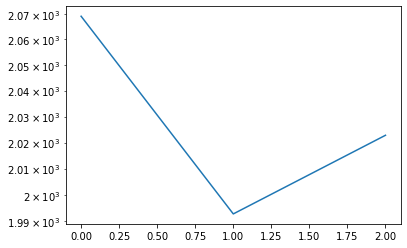

In [104]:
plt.plot(l)
plt.yscale('log')

## Plot Frames Loss

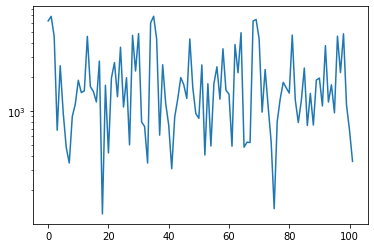

In [105]:
r = 1
plt.plot([sum(la[i:i+r])/r for i in range(0,len(la),r)])
plt.yscale('log')

## Prediction

In [12]:
def Prediction(Vid,Params):
    P = []
    V = [torch.tensor(cv2.resize(i,(320,320),interpolation=cv2.INTER_AREA),
                              dtype=torch.float32).permute(2,0,1).unsqueeze(0)/255.0 for i in Vid]
    k,kt,kb = Extract(Params)
    N = len(kt)//2
    for f in range(len(V) - 2 * N):
        first, current, last = f, f + N // 2, f + N
        Pred = ObjFun(V[first:last], V[current], k, kt, kb)
        P.append(cv2.resize((Pred[0] * 255).squeeze(0).permute(1, 2, 0).detach().cpu().numpy().astype(np.uint8),
                                           (Vid[f].shape[1], Vid[f].shape[0]), interpolation=cv2.INTER_AREA))
    return P

In [30]:
Parameters = torch.load("paramstimedof.pth")
cap = open_vid("AI Gen/movie(17).mp4")
Video = get_frames(cap)

In [31]:
PVid = Prediction(Video[:30],Parameters)

In [32]:
ThroughFrames(PVid)